# 한글 Word2Vec 만들기

In [1]:
# KoNLPy 설치
!pip install konlpy

     |████████████████████████████████| 19.4 MB 59.6 MB/s 
     |████████████████████████████████| 448 kB 21.9 MB/s 


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", sep = '\t')
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


- 데이터 전처리

In [6]:
# 중복 여부 확인
df.shape, df.document.nunique()

((200000, 3), 194543)

In [7]:
# 중복 데이터 배제
df.drop_duplicates(subset= ['document'], inplace = True)
df.shape

(194544, 3)

In [11]:
# Null 데이터 있는지 확인
df.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [10]:
# Null data 제거
df.dropna(how = 'any', inplace= True)

In [12]:
# 한글 이외의 문자는 공백으로 처리하고 strip
df.document = df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
df.head(3)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1


In [15]:
# ' ' 만 남은 데이터 --> np.nan으로 변경시킨 후 제거
df.document.replace('', np.nan, inplace=True)
df.document.isna().sum()

1025

In [17]:
# Null data 제거
df.dropna(how = 'any', inplace= True)
df.shape

(193518, 3)

### 한글 형태소 분석

In [23]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','.',',','?','!','\'','"']


In [24]:
okt = Okt()
print(okt.morphs("토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능합니다."))

['토큰', '화가', '된', '상태', '에서는', '각', '리뷰', '의', '길이', '분포', '또한', '확인', '이', '가능합니다', '.']


In [25]:
# 어근만 가져와라
print(okt.morphs('토큰화가 된 상태에서는, 각 리뷰의 길이 "분포" 또한 확인이 가능합니다.', stem = True))
# stopwords 제거 안했기 때문에 남아 있다.

['토큰', '화가', '되다', '상태', '에서는', ',', '각', '리뷰', '의', '길이', '"', '분포', '"', '또한', '확인', '이', '가능하다', '.']


In [28]:
from tqdm.notebook import tqdm

tokenized_data = []
for sentence in tqdm(df.document):
    morphs = okt.morphs(sentence, stem = True)
    morphs = [word for word in morphs if word not in stopwords]
    tokenized_data.append(morphs)

  0%|          | 0/193518 [00:00<?, ?it/s]

리뷰의 최대 길이 : 73
리뷰의 평균 길이 : 11.04329829783276


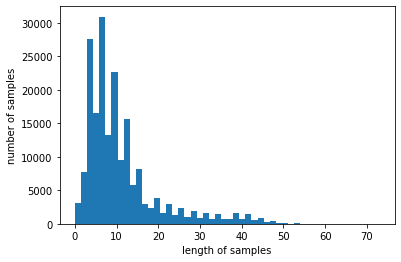

In [29]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Word2Vec 훈련 시키기

In [31]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [32]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16376, 100)

In [33]:
model.wv.most_similar("최민식", topn=5)

[('안성기', 0.8736326694488525),
 ('한석규', 0.8709814548492432),
 ('김명민', 0.8665229082107544),
 ('최민수', 0.8657962083816528),
 ('이민호', 0.843999981880188)]

In [34]:
model.wv.most_similar("히어로", topn=5)

[('무협', 0.8783299922943115),
 ('느와르', 0.8615338802337646),
 ('슬래셔', 0.8433445692062378),
 ('정통', 0.8244884014129639),
 ('호러', 0.8208471536636353)]

In [35]:
# 한국 - 서울 + 도쿄
# 영화평으로 학습을 해서 올바른 결과가 나오지 않음
model.wv.most_similar(positive = ['한국', '도쿄'], negative=['서울'], topn=3)

[('정석', 0.6945218443870544),
 ('할리우드', 0.6919634342193604),
 ('국산', 0.679619550704956)]

In [37]:
# 황정민 - 느와르 + 멜로
model.wv.most_similar(positive = ['황정민', '멜로'], negative=['느와르'], topn=10)

[('서우', 0.8089120388031006),
 ('임수정', 0.7958583235740662),
 ('유해진', 0.7921563982963562),
 ('김하늘', 0.7915682792663574),
 ('이연희', 0.7894455790519714),
 ('장나라', 0.7893222570419312),
 ('신민아', 0.788908839225769),
 ('박신혜', 0.7860382795333862),
 ('신하균', 0.7824032306671143),
 ('유아인', 0.7794708609580994)]

In [ ]:
# 말뭉치(ex)soy)를 멀 사용하는지에 따라 결과값이 달라진다. 
# 